In [5]:

from pathlib import Path
import xmltodict
from tqdm import tqdm
import pandas as pd

# --- Đường dẫn ---
image_dir = Path("Classification/JPEGImages")   # thư mục ảnh
merged_dir = Path("Last/Predicted_XML")                 # thư mục chứa XML

# --- Lấy danh sách file XML ---
xml_files = sorted(list(merged_dir.glob("*.xml")))

# --- Biến lưu thống kê ---
label_stats = {}         # {label: {"images": set(), "boxes": int}}
total_boxes = 0

# --- Đọc từng XML ---
for xml_path in tqdm(xml_files, desc="Đang đọc nhãn"):
    with open(xml_path, 'r') as f:
        anno = xmltodict.parse(f.read()).get("annotation", {})
    objs = anno.get("object", [])
    if not objs:
        continue
    if not isinstance(objs, list):
        objs = [objs]

    img_name = xml_path.stem + ".jpg"

    for obj in objs:
        label = obj.get("name", "").strip()
        if not label:
            continue

        total_boxes += 1
        if label not in label_stats:
            label_stats[label] = {"images": set(), "boxes": 0}
        label_stats[label]["images"].add(img_name)
        label_stats[label]["boxes"] += 1

# --- Tổng hợp dữ liệu ---
data = []
for label, info in label_stats.items():
    data.append({
        "Label": label,
        "Số ảnh chứa nhãn": len(info["images"]),
        "Số bounding box": info["boxes"]
    })

df = pd.DataFrame(data).sort_values(by="Số bounding box", ascending=False)

# --- Tổng quan ---
print("📊 TỔNG QUAN DATASET")
print(f"Tổng số file XML: {len(xml_files)}")
print(f"Tổng số loại nhãn: {len(label_stats)}")
print(f"Tổng số bounding box: {total_boxes}")
print(f"Tổng số ảnh có nhãn: {len(set([img for v in label_stats.values() for img in v['images']]))}")

print("\n📋 THỐNG KÊ CHI TIẾT THEO NHÃN:")
display(df)

# --- Lưu kết quả ra file Excel ---
output_path = "dataset_statistics.xlsx"
df.to_excel(output_path, index=False)
print(f"\n📁 Đã lưu kết quả thống kê vào: {output_path}")


Đang đọc nhãn: 100%|██████████| 1457/1457 [00:23<00:00, 62.04it/s]

📊 TỔNG QUAN DATASET
Tổng số file XML: 1457
Tổng số loại nhãn: 5
Tổng số bounding box: 44960
Tổng số ảnh có nhãn: 1457

📋 THỐNG KÊ CHI TIẾT THEO NHÃN:


,Label,Số ảnh chứa nhãn,Số bounding box
0,nodules,1441,21186
2,acne-types,1326,10713
1,comedones,1238,8698
3,papules,980,4314
4,unknown,1,49



📁 Đã lưu kết quả thống kê vào: dataset_statistics.xlsx


📦 KIỂM TRA TÍNH TOÀN VẸN DỮ LIỆU

✅ Không có ảnh nào bị thiếu XML
✅ Không có XML nào bị thiếu ảnh


Đang đọc nhãn: 100%|██████████| 1457/1457 [00:01<00:00, 930.17it/s] 


📊 TỔNG QUAN DATASET
Tổng số XML: 1457
Tổng số loại nhãn: 5
Tổng số bounding box: 44960
Tổng số ảnh có nhãn: 1457

📋 THỐNG KÊ CHI TIẾT THEO NHÃN:


,Label,Số ảnh chứa nhãn,Số bounding box
0,nodules,1441,21186
2,acne-types,1326,10713
1,comedones,1238,8698
3,papules,980,4314
4,unknown,1,49



💾 Đã lưu file thống kê: dataset_statistics.xlsx


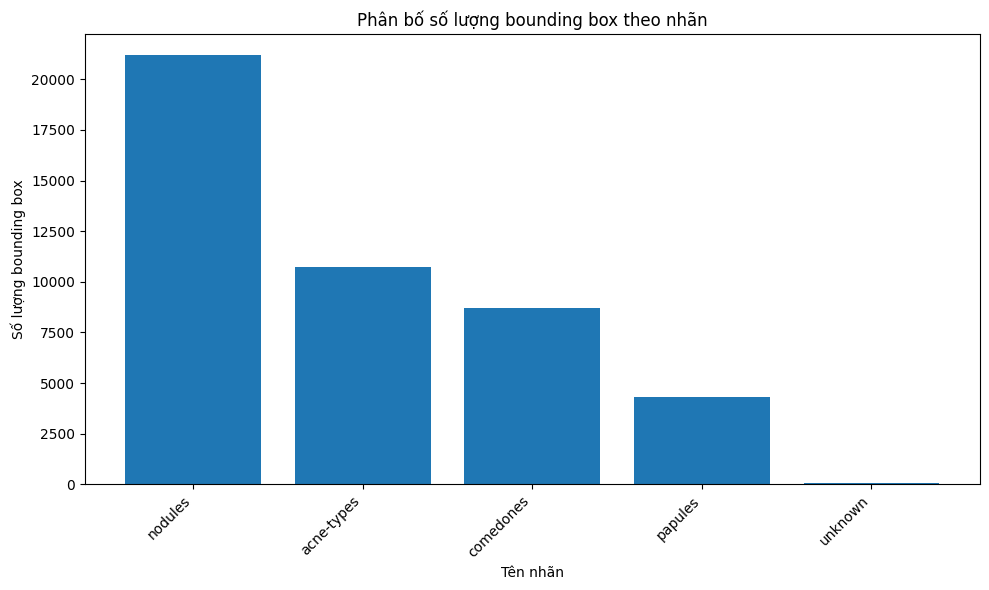

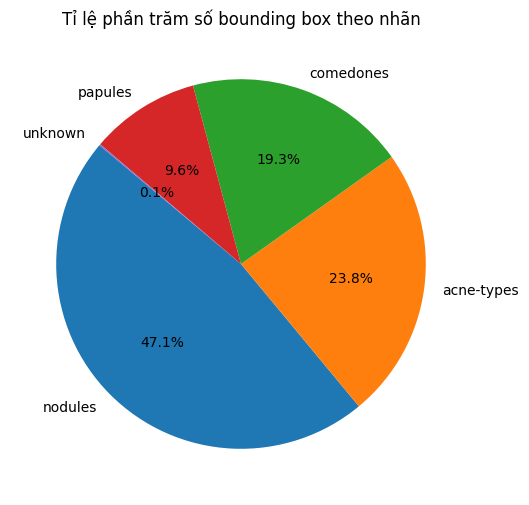


🖼️ HIỂN THỊ 5 ẢNH ĐẦU TIÊN:


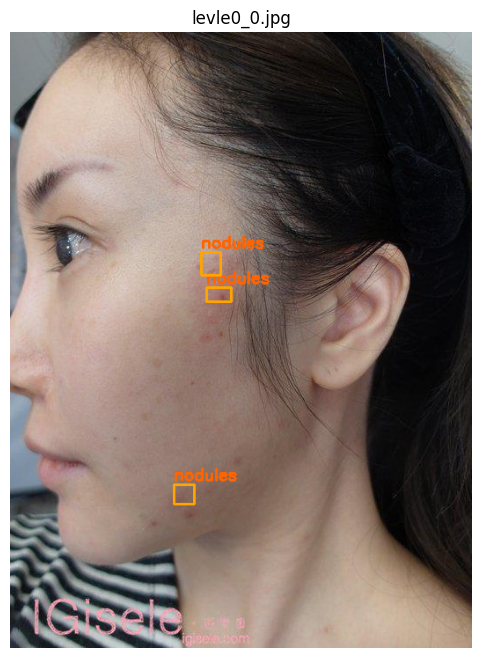

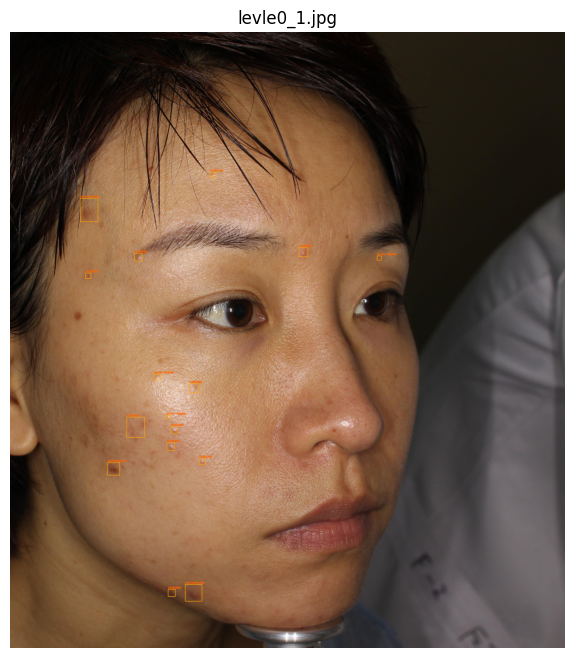

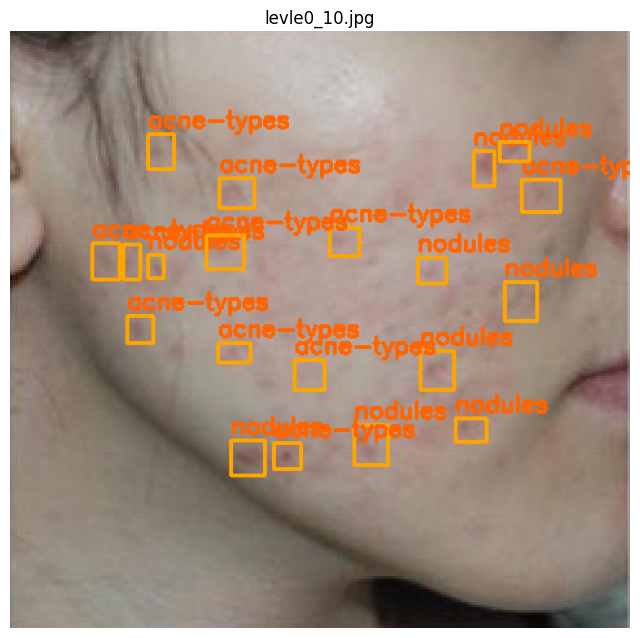

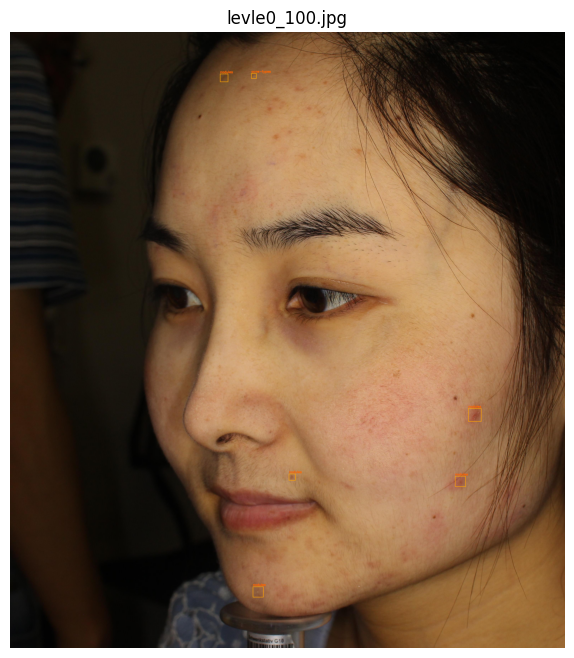

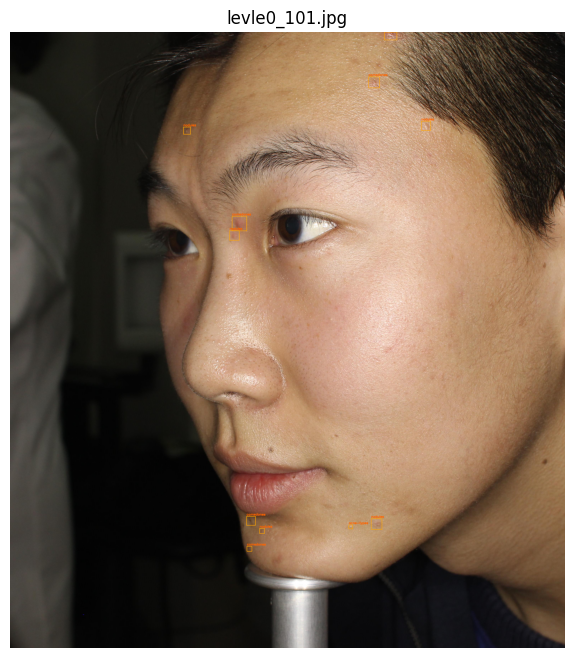

In [2]:

from pathlib import Path
import xmltodict
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# =========================================================
# 🗂️ ĐƯỜNG DẪN
# =========================================================
image_dir = Path("Classification/JPEGImages")   # ảnh gốc
merged_dir = Path("Last\Predicted_XML")                 # file XML gộp

# =========================================================
# 🧾 HÀM ĐỌC BOUNDING BOX TỪ XML
# =========================================================
def read_boxes(xml_path):
    boxes = []
    with open(xml_path, 'r') as f:
        anno = xmltodict.parse(f.read()).get("annotation", {})
    objects = anno.get("object", [])
    if not isinstance(objects, list):
        objects = [objects]
    for obj in objects:
        try:
            name = obj["name"]
            box = obj["bndbox"]
            x1, y1, x2, y2 = map(int, [box["xmin"], box["ymin"], box["xmax"], box["ymax"]])
            boxes.append((name, x1, y1, x2, y2))
        except:
            continue
    return boxes

# =========================================================
# 🔍 BƯỚC 1: KIỂM TRA DỮ LIỆU CÓ BỊ THIẾU KHÔNG
# =========================================================
xml_files = sorted(list(merged_dir.glob("*.xml")))
img_files = sorted(list(image_dir.glob("*.jpg")))

xml_stems = set(f.stem for f in xml_files)
img_stems = set(f.stem for f in img_files)

print("📦 KIỂM TRA TÍNH TOÀN VẸN DỮ LIỆU\n")

missing_xml = img_stems - xml_stems
missing_img = xml_stems - img_stems

if missing_xml:
    print(f"⚠️ Ảnh thiếu XML: {len(missing_xml)}")
else:
    print("✅ Không có ảnh nào bị thiếu XML")

if missing_img:
    print(f"⚠️ XML thiếu ảnh: {len(missing_img)}")
else:
    print("✅ Không có XML nào bị thiếu ảnh")

# =========================================================
# 📊 BƯỚC 2: THỐNG KÊ TOÀN BỘ NHÃN
# =========================================================
label_stats = {}   # {label: {"images": set(), "boxes": int}}
total_boxes = 0

for xml_path in tqdm(xml_files, desc="Đang đọc nhãn"):
    with open(xml_path, 'r') as f:
        anno = xmltodict.parse(f.read()).get("annotation", {})
    objs = anno.get("object", [])
    if not objs:
        continue
    if not isinstance(objs, list):
        objs = [objs]

    img_name = xml_path.stem + ".jpg"

    for obj in objs:
        label = obj.get("name", "").strip()
        if not label:
            continue
        total_boxes += 1
        if label not in label_stats:
            label_stats[label] = {"images": set(), "boxes": 0}
        label_stats[label]["images"].add(img_name)
        label_stats[label]["boxes"] += 1

# === Tạo bảng thống kê ===
data = []
for label, info in label_stats.items():
    data.append({
        "Label": label,
        "Số ảnh chứa nhãn": len(info["images"]),
        "Số bounding box": info["boxes"]
    })
df = pd.DataFrame(data).sort_values(by="Số bounding box", ascending=False)

# === In kết quả tổng quan ===
print("\n📊 TỔNG QUAN DATASET")
print(f"Tổng số XML: {len(xml_files)}")
print(f"Tổng số loại nhãn: {len(df)}")
print(f"Tổng số bounding box: {total_boxes}")
print(f"Tổng số ảnh có nhãn: {len(set([img for v in label_stats.values() for img in v['images']]))}")

print("\n📋 THỐNG KÊ CHI TIẾT THEO NHÃN:")
display(df)

# === Lưu ra file Excel ===
df.to_excel("dataset_statistics.xlsx", index=False)
print("\n💾 Đã lưu file thống kê: dataset_statistics.xlsx")

# =========================================================
# 📈 BƯỚC 3: VẼ BIỂU ĐỒ PHÂN BỐ NHÃN
# =========================================================
plt.figure(figsize=(10,6))
plt.bar(df["Label"], df["Số bounding box"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Tên nhãn")
plt.ylabel("Số lượng bounding box")
plt.title("Phân bố số lượng bounding box theo nhãn")
plt.tight_layout()
plt.show()

# Biểu đồ tròn tỉ lệ nhãn
plt.figure(figsize=(6,6))
plt.pie(df["Số bounding box"], labels=df["Label"], autopct='%1.1f%%', startangle=140)
plt.title("Tỉ lệ phần trăm số bounding box theo nhãn")
plt.show()

# =========================================================
# 🖼️ BƯỚC 4: VISUALIZE ẢNH VỚI NHÃN (KIỂM TRA BẰNG MẮT)
# =========================================================
def visualize_merged(img_name):
    img_path = image_dir / img_name
    xml_path = merged_dir / f"{Path(img_name).stem}.xml"

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"⚠️ Không tìm thấy ảnh: {img_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for name, x1, y1, x2, y2 in read_boxes(xml_path):
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 165, 0), 2)
        cv2.putText(img, name, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 100, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")
    plt.show()

# === Hiển thị 5 ảnh đầu tiên ===
print("\n🖼️ HIỂN THỊ 5 ẢNH ĐẦU TIÊN:")
for xml in xml_files[:5]:
    img_name = xml.stem + ".jpg"
    visualize_merged(img_name)
